# Case study 1: Simulation with a SARS-CoV-2 Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image

from eliater import version_df
from eliater.discover_latent_nodes import find_nuisance_variables, remove_nuisance_variables
from eliater.examples.sars_cov2 import sars_large_example as example
from eliater.network_validation import print_graph_falsifications
from y0.algorithm.estimation import estimate_ace
from y0.algorithm.identify import Identification, identify_outcomes
from y0.dsl import P, Variable

version_df()

,key,value
0,eliater,0.0.3-dev-fe2458c7
1,y0,0.2.12-dev-fe2458c7
2,Run at,2024-05-25 08:12:53


In [2]:
treatment = Variable("EGFR")
outcome = Variable("cytok")
SEED = 10

This is case study 1 in Figure 6 in this paper: Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The figure below shows the SARS-CoV-2 network (Mohammad-Taheri et al., 2022; Zucker
et al., 2021), which models the activation of Cytokine Release Syndrome (Cytokine Storm), a known factor causing tissue damage in severely ill SARS-CoV-2 patients (Ulhaq and Soraya, 2020).

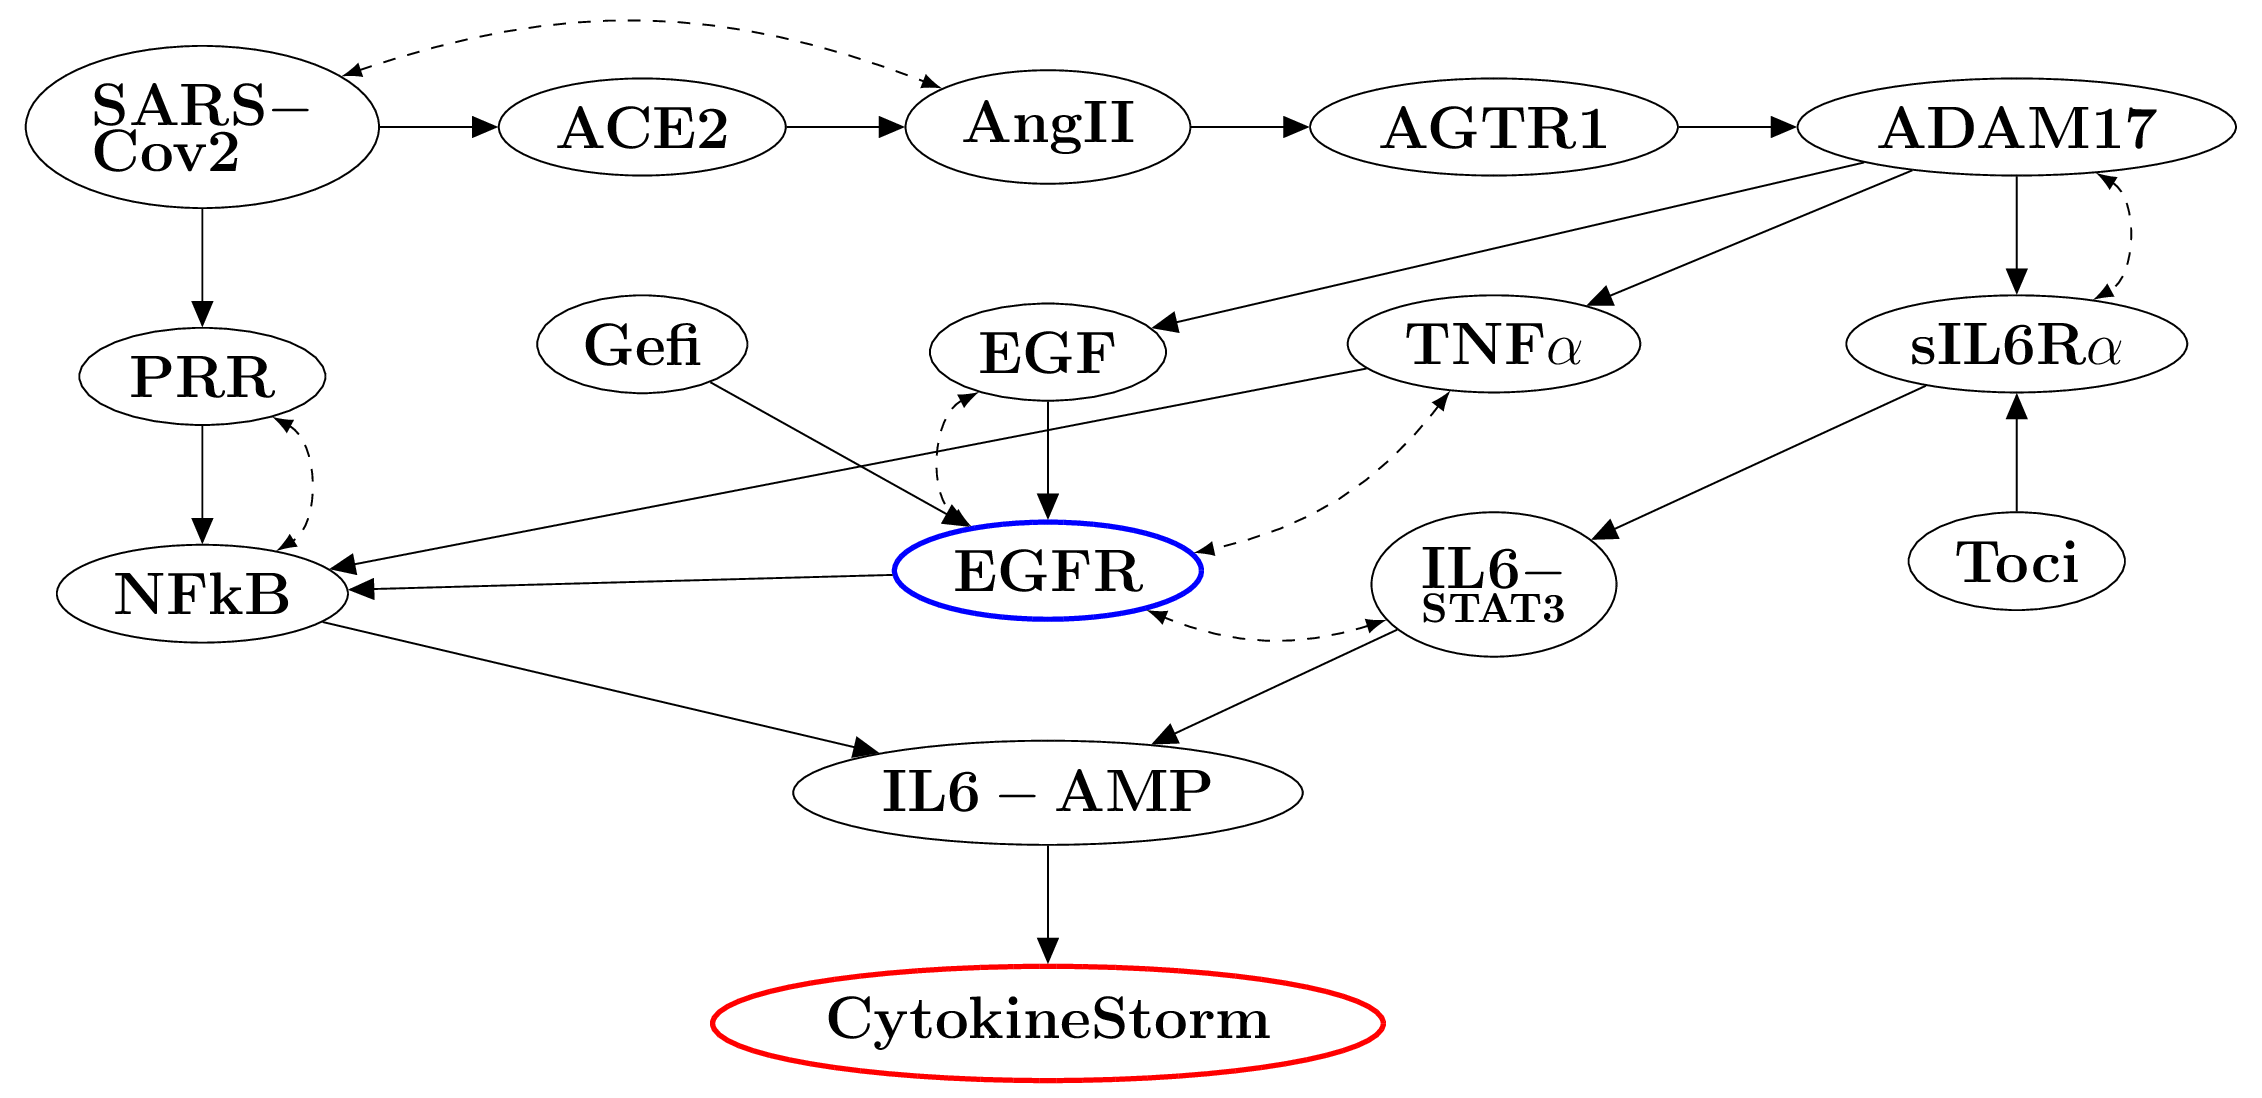

In [3]:
Image(filename="../img/SARS_COV.png", width=500, height=500)

In [4]:
graph = example.graph

This case study used synthetic observational data. The generation of this synthetic data was inspired by common biological practices.  The exogenous variables were modeled with a Gaussian distribution. For each endogenous variable $X$, we represented  biomolecular reactions using Hill equations \cite{alon2019introduction}, and were approximated with a sigmoid function as follows,

$\mathcal{N}(\frac{100}{1 + \exp(\mathbf{\theta}^{\prime} Pa(X) + \theta_0)})$ 

where $Pa(X)$ is a $q \times 1$ vector of measurements related to the parent of $X$, $\mathbf{\theta}'$ is a $1 \times q$ parameter vector, and $\theta_0$ is a scalar. The $EGFR$ was generated from a Binomial distribution with probability of $\frac{1}{1 + \exp(\mathbf{\theta}^{\prime} Pa(X) + \theta_0)}$. Hence, the observational data is mixed-type where the $EGFR$ column is binary (discrete), and rest of columns are continuous.

In [5]:
# get observational data
# data = example.generate_data(1000, seed=SEED)
data = example.generate_data(1000, seed=SEED)
data.head()

,SARS_COV2,ACE2,Ang,AGTR1,ADAM17,Toci,Sil6r,EGF,TNF,Gefi,EGFR,PRR,NFKB,IL6STAT3,IL6AMP,cytok
0,74.818466,18.273505,94.393956,98.801910,99.256863,36.651069,85.881712,94.749073,99.863592,33.966616,1,99.518860,34.272531,33.312144,43.843032,67.926041
1,50.907438,36.711375,67.699182,99.294325,96.954993,52.899809,75.568726,94.950873,98.934965,37.749754,1,88.868626,32.037571,71.296943,69.477027,91.129469
2,76.434215,17.909068,94.771813,100.384201,100.226176,42.669583,87.432246,95.490495,99.403036,37.181947,1,96.605436,35.853639,59.013137,61.840728,85.813060
3,72.508174,19.305827,93.568645,99.296364,99.259188,46.082585,71.540865,96.506473,99.042601,47.669759,1,96.954760,39.201726,20.074860,35.928344,56.811495
4,63.747777,26.183989,87.636441,98.737421,99.825670,55.442630,86.093502,96.710827,100.583294,42.514193,1,94.118504,29.089479,41.607462,45.669105,69.531180


In [6]:
data["EGFR"].mean()

0.81

## Step 1: Verify correctness of the network structure

We checked the consistency of the network structure against observational data with significance level of 0.01 by first discretizing the data into a binary data and used the $\chi$-square test. This is because \texttt{Eliater} does not support mixed-type data.  

In [7]:
from sklearn.preprocessing import KBinsDiscretizer

# discretization transform the raw data
kbins = KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform")
data_trans = kbins.fit_transform(data)

In [8]:
data_trans = pd.DataFrame(data_trans, columns=data.columns)

In [9]:
data_trans

,SARS_COV2,ACE2,Ang,AGTR1,ADAM17,Toci,Sil6r,EGF,TNF,Gefi,EGFR,PRR,NFKB,IL6STAT3,IL6AMP,cytok
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
996,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
997,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
998,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
print_graph_falsifications(
    graph=graph, data=data_trans, method="chi-square", verbose=True, significance_level=0.01
)

Of the 99 d-separations implied by the network's structure, only 8(8.08%) rejected the null hypothesis at p<0.01.

Since this is less than 30%, Eliater considers this minor and leaves the network unmodified.]

Finished in 18.56 seconds.


,left,right,given,stats,p,dof,p_adj,p_adj_significant
0,Ang,PRR,SARS_COV2,129.576151,0.000000e+00,1,0.000000e+00,True
1,ACE2,PRR,SARS_COV2,59.926060,9.880985e-15,1,9.683365e-13,True
2,Sil6r,cytok,IL6AMP,56.109967,6.850076e-14,1,6.644574e-12,True
3,IL6STAT3,cytok,IL6AMP,44.325091,2.781286e-11,1,2.670035e-09,True
4,AGTR1,PRR,Ang,33.709663,6.398209e-09,1,6.078298e-07,True
...,...,...,...,...,...,...,...,...
94,ACE2,AGTR1,Ang,0.000000,NaN,0,NaN,False
95,AGTR1,SARS_COV2,Ang,0.000000,NaN,0,NaN,False
96,ADAM17,SARS_COV2,AGTR1,0.000000,NaN,0,NaN,False
97,ADAM17,Ang,AGTR1,0.000000,NaN,0,NaN,False


Among all the 99 possible tests, 10 failed (10 $\%$). As the data was synthetically generated based on the network structure, we expected all the tests to pass. However the failed tests are due to noise inherited by randomly sampling the data points. 

## Step 2: Check query identifiability

In [11]:
identify_outcomes(graph=graph, treatments=treatment, outcomes=outcome)

Sum[ACE2, ADAM17, AGTR1, Ang, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci](P(ACE2 | SARS_COV2) * P(AGTR1 | ACE2, Ang, SARS_COV2) * P(IL6AMP | ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci) * P(IL6STAT3 | ACE2, ADAM17, AGTR1, Ang, SARS_COV2, Sil6r, Toci) * P(TNF | ACE2, ADAM17, AGTR1, Ang, SARS_COV2) * P(cytok | ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci) * Sum[ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, cytok](P(ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci, cytok)) * P(ADAM17 | ACE2, AGTR1, Ang, SARS_COV2, Toci) * P(Sil6r | ACE2, ADAM17, AGTR1, Ang, SARS_COV2, Toci) * P(Ang | ACE2, SARS_COV2) * P(SARS_COV2) * P(NFKB | ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, PRR, SARS_COV2, TNF) * P(PRR | ACE2, Gefi, SARS_COV2))

The query is identifiable.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [12]:
nuisance_variables = find_nuisance_variables(graph, treatments=treatment, outcomes=outcome)
nuisance_variables

set()

No variable is identified as the nuisance variable. Hence the simplified network in the next step will produce a graph similar to the original graph.

## Step 4: Simplify the network

In eliater, step 3, and 4 are both combined into a single function. Hence, the following function finds the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules (Step 4) to remove the nuisance variables. As a result, running the 'find_nuisance_variables' and 'mark_nuisance_variables_as_latent' functions is not necessary to get the value of step 4. However, we called them to illustrate the results.  As there are no nuisance variables, the new graph will be the same as the original graph.

In [13]:
new_graph = remove_nuisance_variables(graph, treatments=treatment, outcomes=outcome)

## Step 5: Estimate the query

In [14]:
estimate_ace(new_graph, treatments=treatment, outcomes=outcome, data=data)

0.6306584226679632

## Evaluation criterion
As we used synthetic data set, we were able to generate two interventional data sets where in
one EGFR was set to 1, and the other one EGFR is set to 0. The ATE was calculated by subtracting the average value of Cytokine Storm obtained from each interventional data,
resulting in the ground truth ATE=0.796. The positive ATE indicates that the Gefitinib drug can not reduce the Cytokine Storm levels, hence can't help in treating patients having SARS-Cov-2.

In [15]:
def get_background_ace(seed=None) -> float:
    # get interventional data where treatment is set to 1
    data_1 = example.generate_data(1000, {treatment: 1.0}, seed=seed)
    # get interventional data where treatment is set to 0
    data_0 = example.generate_data(1000, {treatment: 0.0}, seed=seed)
    return data_1.mean()[outcome.name] - data_0.mean()[outcome.name]


# get the true value of ATE
get_background_ace(seed=SEED)

0.7944416772404566

### Random Sampling Evaluation

For this case study, since the observational data is synthetic, we generated multiple sub-samples from the observational data and for each sub-sampled data, estimated the value of ATE. Hence, we have a range of ATE values instead of a point estimate that we got in the step 5 above. This will help to interpret the results better. The first quantile of the range of estimated ATEs was 0.358 and third quantile was 0.821 which covers the ground truth $\mathrm{ATE}$ of 0.794$. 

In [16]:
# Population => Generate D = 10000 data points
D = example.generate_data(10000, seed=SEED)

In [17]:
# Samples => Generate 1000 datasets with 1000 points each (d) using random sampling
d_count = 1000
d_size = 1000
d = [D.sample(d_size) for _ in range(d_count)]

In [18]:
ate = [estimate_ace(new_graph, treatments=treatment, outcomes=outcome, data=data) for data in d]

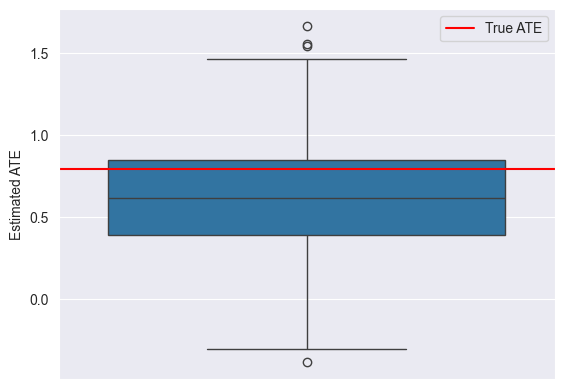

In [19]:
ax = sns.boxplot(y=ate)
ax.axhline(y=get_background_ace(seed=SEED), label="True ATE", color="r")
ax.set(ylabel="Estimated ATE")
ax.legend()
# plt.savefig("/Users/sarataheri/GitHub/eliater/img/Sars_ATE_boxplot.png")

In [20]:
np.percentile(ate, 25)

0.3866641254099896

In [21]:
np.percentile(ate, 75)

0.8481888593554885